# Esercitazione 12

Elisa Stabilini - 942529

In [1]:
# importazione librerie
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
import string
from scipy.optimize import curve_fit
from numpy.lib.polynomial import poly

warnings.filterwarnings('ignore')
params = {'legend.fontsize': 'x-large', 'figure.figsize': (10, 6), 'axes.labelsize': 'x-large', 'axes.titlesize':'xx-large', 'xtick.labelsize':'x-large', 'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras import optimizers, losses, metrics
from keras.datasets import mnist 
from keras.layers import Dense, Dropout

from PIL import Image
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' #This is needed in my Anaconda+MacOsX installation; leave it commented.

2022-08-29 07:32:38.247041: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-29 07:32:38.249848: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-29 07:32:38.249856: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


L'obiettivo di questa esercitazione è quello di allenare una rete neurale a riconoscere delle cifre scritte a mano. Per farlo sono utilizzate le immagini messe a disposizione dalla base dati MNIST. Ciascuna immagine è costituita da un quadrato di $28 \times 28$ pixel, a ciascuno dei quali è assegnato un valore tra 256 possibili in scala di grigi (dal bianco al nero). A ciascuna immagine è inoltre associata un'etichetta che reca l'output atteso dalla rete.

## Esercizio 1

**Caricamento e organizzazione dati**

In [3]:
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

In [4]:
from keras.datasets import mnist

# dimensioni immagine di input
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)

X_test shape: (10000, 28, 28)
Y_test shape: (10000,)


In [5]:
# reshape data, it could depend on Keras backend.
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print()

# cast floats to single precision
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices
Y_train = keras.utils.to_categorical(Y_train, num_classes) #la label della cifra è diventata un vettore di "bit", che potrà essere confrontata direttamente con l'output
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (60000, 784)
X_test shape: (10000, 784)


X_train shape: (60000, 784)
Y_train shape: (60000, 10)


**Definzione della rete neurale e della sua architetura**

Costruisco una rete neualre profonda aggiungendo diversi *layers*, l'input è quello definito sopra (vettore di 784 valori).
L'ultimo strato della rete neurale è l'output, essendo quello del riconoscimento cifre scritte a mano un problema di classificazione (ho 10 categorie per l'output, ovvero 10 possibile cifre che possono corrispondere all'input), l'output sarà costituito da 10 neuroni con funzione di attivazione `softmax`.

In [6]:
def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))    
    
    return model

print('Model architecture created successfully!')

Model architecture created successfully!


**Scelta dell'ottimizzatore e della funzione costo**

Per i problemi di classificazione la *loss function* che viene generalmente utilizzata è la *cross entropy*. Per facilitare il confronto tra l'output e l'etichetta associata a ciascuna immagine la seconda è stata precedentemente convertita in un vettore di 10 elementi utilizzando `to_categorical`. A questo punto, con input e output della stessa formula la funzione costo che è stata utilizzata è `categorical_crossentropy()`.

In [7]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adamax, Nadam

def compile_model(opt):
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt,
                  metrics=['acc'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


**Training del modello**

In [8]:
# training parameters
batch_size = 60
epochs = 10

optimizers = [SGD(), Adam(), Adagrad(), Adamax()]
names = ['SGD','Adam', 'Adagrad', 'Adamax']

# create the deep neural net (list with models using different optimizers)
model_DNN = [compile_model(optimizer) for optimizer in optimizers]
for model in model_DNN:
    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 400)               314000    
                                                                 
 dense_1 (Dense)             (None, 100)               40100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 355,110
Trainable params: 355,110
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)            

2022-08-29 07:33:52.185646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 07:33:52.186256: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-29 07:33:52.186327: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-08-29 07:33:52.186386: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-08-29 07:33:52.186449: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [9]:
# train DNN and store training info in history
histories = [model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test)
                      ) for model in model_DNN]

Epoch 1/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.9415 - acc: 0.7242 - val_loss: 0.3834 - val_acc: 0.9013
Epoch 2/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4665 - acc: 0.8680 - val_loss: 0.2948 - val_acc: 0.9188
Epoch 3/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3818 - acc: 0.8927 - val_loss: 0.2516 - val_acc: 0.9294
Epoch 4/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3360 - acc: 0.9054 - val_loss: 0.2248 - val_acc: 0.9361
Epoch 5/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2990 - acc: 0.9155 - val_loss: 0.2059 - val_acc: 0.9406
Epoch 6/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2780 - acc: 0.9223 - val_loss: 0.1904 - val_acc: 0.9454
Epoch 7/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2541 - acc: 0.9290 - val_loss: 0.1765 - val_acc: 0.9476
Epoch 8/10
1000/1000 [==============================] - 2s 2ms

**Valutazione delle prestazioni del modello**

Per valutare la prestazione dei diversi modelli di rete che sono stati implementati (ovvero dell'efficienza dei diversi ottimizzatori) utilizzo `evaluate()` che consente di calcolare la precisione delle predizioni del modello usi dati di test (dati nuovi dal punto di vista della rete neurale).

SGD
  Test loss: 0.14841622114181519
  Test accuracy: 0.953499972820282
Adam
  Test loss: 0.08564244955778122
  Test accuracy: 0.9810000061988831
Adagrad
  Test loss: 0.29314032196998596
  Test accuracy: 0.9192000031471252
Adamax
  Test loss: 0.06295662373304367
  Test accuracy: 0.9807999730110168


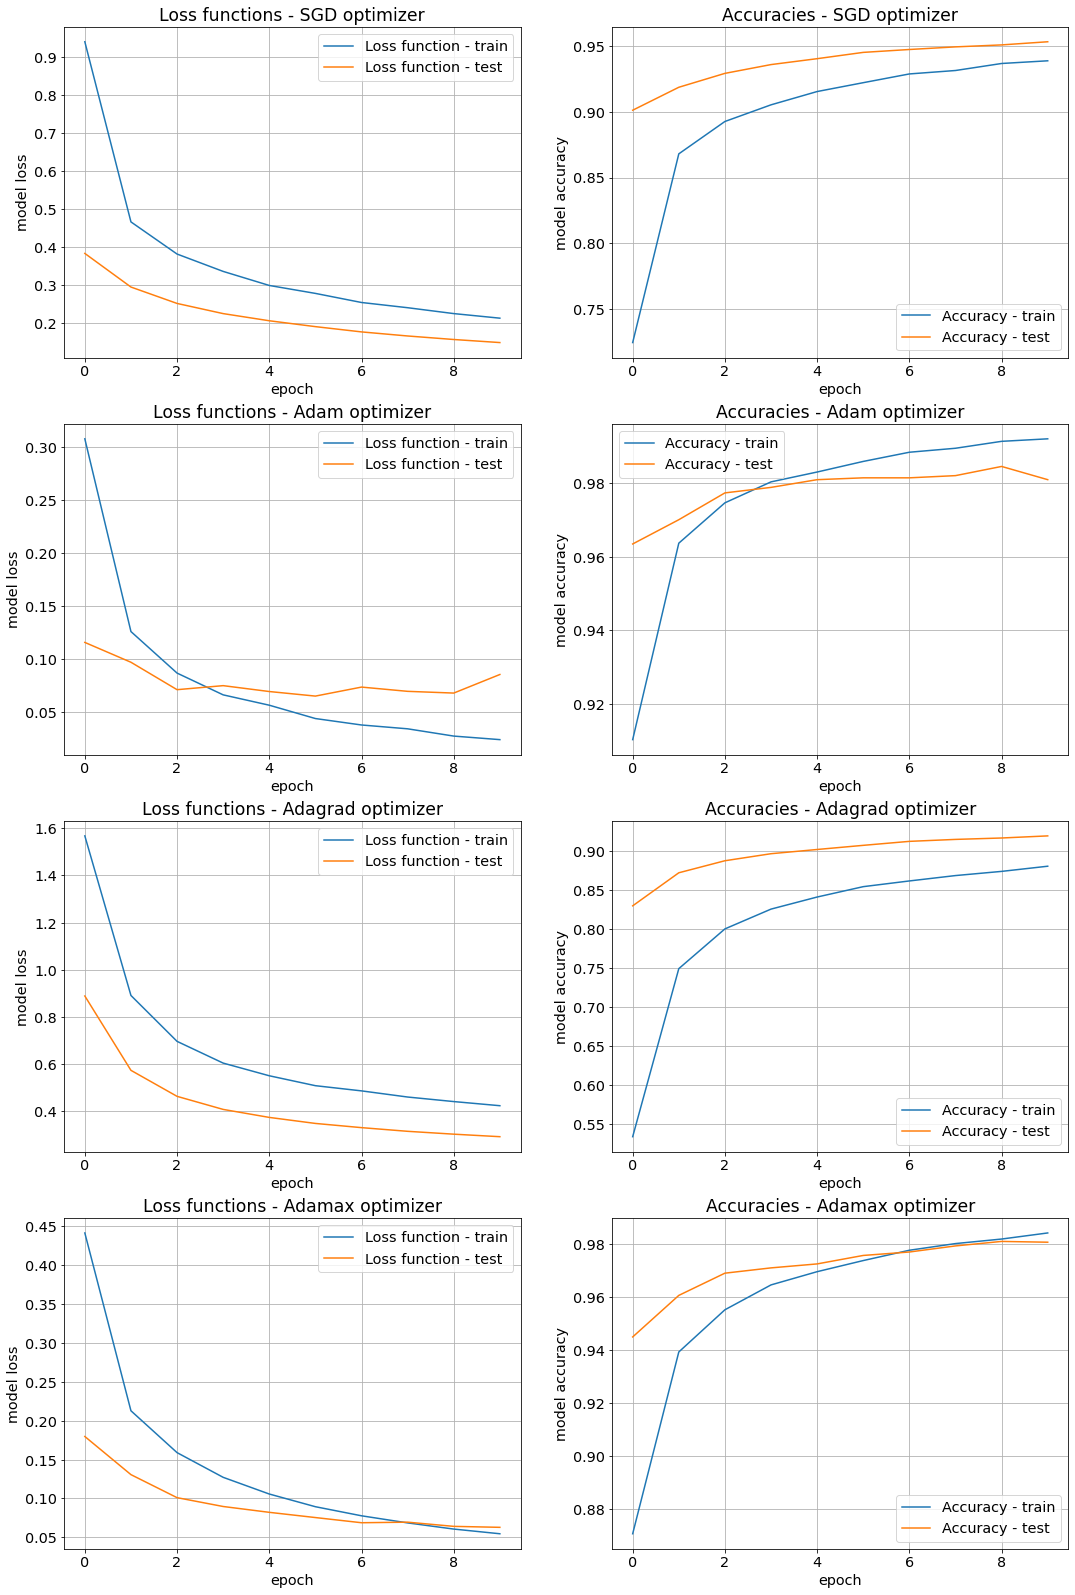

In [49]:
# evaluate model
scores = [model.evaluate(X_test, Y_test, verbose=0) for model in model_DNN]

# print performance
for i in range(len(optimizers)):
    print(str(names[i]))
    print('  Test loss:', scores[i][0])
    print('  Test accuracy:', scores[i][1])

# look into training history
fig, plts = plt.subplots(len(optimizers), 2)
fig.set_figwidth(18)
fig.set_figheight(7*len(optimizers))

for i in range(len(optimizers)):
    #summarize history for loss 
    plts[i][0].set_title("Loss functions - " + names[i] + ' optimizer')
    plts[i][0].plot(histories[i].history['loss'])
    plts[i][0].plot(histories[i].history['val_loss'])
    plts[i][0].set_ylabel('model loss')
    plts[i][0].set_xlabel('epoch')
    plts[i][0].legend(['Loss function - train', 'Loss function - test'], loc='best')
    plts[i][0].grid()
    # summarize history for accuracy
    plts[i][1].set_title("Accuracies - " + names[i] + ' optimizer')
    plts[i][1].plot(histories[i].history['acc'])
    plts[i][1].plot(histories[i].history['val_acc'])
    plts[i][1].set_ylabel('model accuracy')
    plts[i][1].set_xlabel('epoch')
    plts[i][1].legend(['Accuracy - train', 'Accuracy - test'], loc='best')
    plts[i][1].grid()

Durante il training il *dropout*, utilizzato per evitare l'*overfitting*, sabota la rete spegnendo alcuni neuroni e quindi peggiorando la predizione della rete, di consegnìuenza le prestazioni sui dati di test, in cui non non si ha *dropout* sono migliori. 

Si osserva che l'ottimizzatore Adam, nonostante l'attivazione del dropout fa convergeere molto rapidamente la funzione costo, questo è probabilmente da imputare ad un overfitting, ovvero ad un adeguamento eccesivo dei parametri della rete neurale ai dati di training, con la conseguenza di una ridotta capacità predittiva del modello all'aumentare delle epoche. 

Per curiosità studio la capacità predittiva di Adamax utilizzando un numero di epoche maggiore variando anche il *learning rate*.

In [73]:
def create_DNN():
    model = Sequential()
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def compile_model(optimizer):
    model=create_DNN()
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['acc'])
    return model

optimizer1 = Adamax(learning_rate=0.005) 
model1 = compile_model(optimizer1)

new_history = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=20,
          verbose=1,
          validation_data=(X_test, Y_test))

scores1 = model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0910 - val_acc: 0.9835
Epoch 2/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0018 - acc: 0.9995 - val_loss: 0.0893 - val_acc: 0.9836
Epoch 3/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0904 - val_acc: 0.9838
Epoch 4/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0014 - acc: 0.9997 - val_loss: 0.0909 - val_acc: 0.9834
Epoch 5/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0013 - acc: 0.9997 - val_loss: 0.0886 - val_acc: 0.9846
Epoch 6/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0896 - val_acc: 0.9840
Epoch 7/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0887 - val_acc: 0.9835
Epoch 8/20
1875/1875 [==============================] - 3s 2ms

  Test loss: 0.08713144809007645
  Test accuracy: 0.9832000136375427


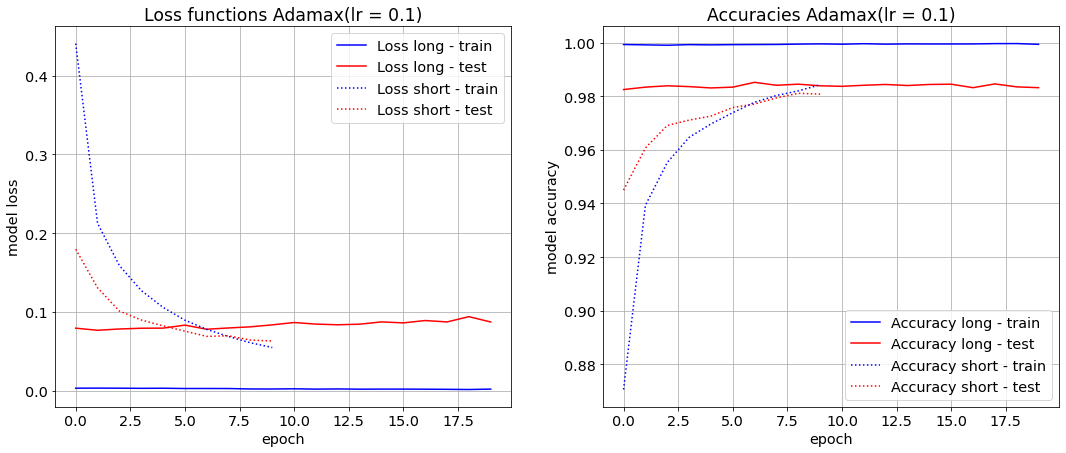

In [72]:
print('  Test loss:', scores1[0])
print('  Test accuracy:', scores1[1])

# look into training history
fig, plts = plt.subplots(1, 2)
fig.set_figwidth(18)
fig.set_figheight(7)

#summarize history for loss 
plts[0].set_title("Loss functions Adamax(lr = 0.005)")
plts[0].plot(new_history.history['loss'], 'b')
plts[0].plot(new_history.history['val_loss'], 'r')
plts[0].plot(histories[3].history['loss'], 'b:')
plts[0].plot(histories[3].history['val_loss'], 'r:')
plts[0].set_ylabel('model loss')
plts[0].set_xlabel('epoch')
plts[0].legend(['Loss long - train', 'Loss long - test', 'Loss short - train', 'Loss short - test'], loc='best')
plts[0].grid()
# summarize history for accuracy
plts[1].set_title("Accuracies Adamax(lr = 0.1)")
plts[1].plot(new_history.history['acc'], 'b')
plts[1].plot(new_history.history['val_acc'], 'r')
plts[1].plot(histories[3].history['acc'], 'b:')
plts[1].plot(histories[3].history['val_acc'], 'r:')
plts[1].set_ylabel('model accuracy')
plts[1].set_xlabel('epoch')
plts[1].legend(['Accuracy long - train', 'Accuracy long - test', 'Accuracy short - train', 'Accuracy short - test'], loc='best')
plts[1].grid()

Come si osservava già nell'esercizio precedente, utilizzando l'ottimizzatore Adamax() la rete neurale va molto velocemente in overfitting. Infatti, anche variando il learnig rate la tendenza rimane quella ad avere predizioni molto accurate in fase di training che però risultano meno performaneti in fase di test.

Concludo l'esercizio confrontando le predizioni dei quattro diversi modelli di rete neurale.

313/313 [==============================] - 0s 559us/step
Risultati in ordine di ottimizzatore usato:
Ottimizzatore SGD
Ottimizzatore Adam
Ottimizzatore Adagrad
Ottimizzatore Adamax


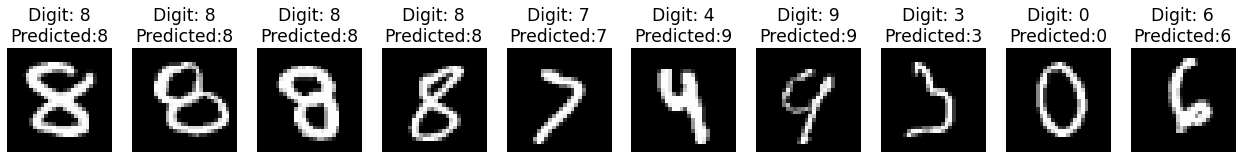

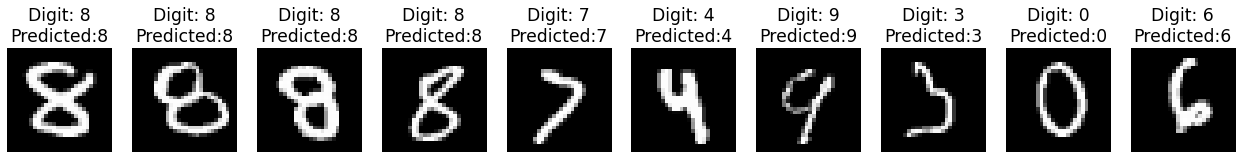

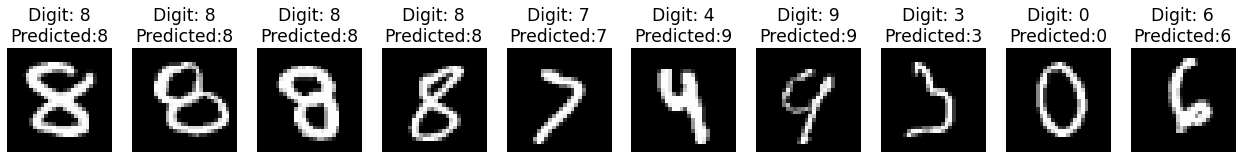

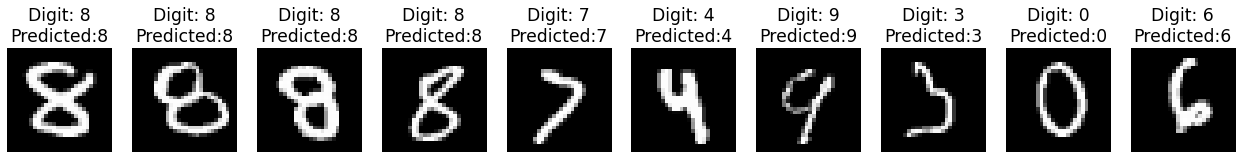

In [30]:
optimizers = [SGD(), Adam(), Adagrad(), Adamax()]
names = ['SGD','Adam', 'Adagrad','Adamax']

X = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = [model.predict(X) for model in model_DNN]

X = X.reshape(X_test.shape[0], img_rows, img_cols,1)

print('Risultati in ordine di ottimizzatore usato:')
for name in names:
    print('Ottimizzatore ' + name)

for j in range(len(optimizers)):
    plt.figure(figsize=(22, 15)) 
    for i in range(10):    
        shift = 876
        ax = plt.subplot(2, 10, i + 1)    
        plt.imshow(X[i+shift, :, :, 0], cmap='gray')    
        plt.title("Digit: {}\nPredicted:{}".format(np.argmax(Y_test[i+shift]), np.argmax(predictions[j][i+shift])))    
        plt.axis('off') 
    plt.show()

## Esercizio 2

Cerco di affronatare il problema preccedente (riconoscimento di cifre scritte a mano) utilizzando una rete neurale convoluzionale (*convolutional neural network - CNN*) anzichè una rete neurale profonda (*deep neural network - DNN*). Le reti neurali convoluzionali hanno infatti il vantaggio di sfruttare l'invariaza traslazionale e le correlazioni spaziali esistenti tra cifre scritte dalla stessa mano.

In [130]:
from keras.layers import Flatten, Conv2D, MaxPooling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


**Creazione del modello**

Nella creazione del modello utilizzo come ottimizzatore l'Adamax(), ovvero quello che ha dato i risultati migliri nella simulazione precedente.

In [131]:
def create_CNN():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape))
    
    # add first max-pooling layer with 2x2 filters
    model.add(MaxPooling2D(pool_size=(2, 2), 
                           strides=2))
    
    # add second convolutional layer with 16 5x5 filters
    model.add(Conv2D(16, kernel_size=(5, 5), 
                     strides=1, 
                     activation='relu',
                     input_shape=input_shape))
    
    # add second max-pooling layer with 2x2 filters
    model.add(MaxPooling2D(strides=2))
    
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    model.add(Flatten())
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adamax(),
                  metrics=['acc'])
    return model

In [132]:
# training parameters
batch_size = 32
epochs = 10

# create the deep conv net
model_CNN=create_CNN()
model_CNN.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 24, 10)        260       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 10)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 16)          4016      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 dropout_22 (Dropout)        (None, 4, 4, 16)          0         
                                                                 
 flatten_2 (Flatten)         (None, 256)             

**Training**

In [55]:
history1 = model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

# evaliate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4803 - acc: 0.8508 - val_loss: 0.1194 - val_acc: 0.9608
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1890 - acc: 0.9429 - val_loss: 0.0836 - val_acc: 0.9754
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1534 - acc: 0.9537 - val_loss: 0.0677 - val_acc: 0.9781
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1332 - acc: 0.9586 - val_loss: 0.0570 - val_acc: 0.9822
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1193 - acc: 0.9632 - val_loss: 0.0507 - val_acc: 0.9842
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1082 - acc: 0.9667 - val_loss: 0.0456 - val_acc: 0.9854
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1026 - acc: 0.9681 - val_loss: 0.0436 - val_acc: 0.9864
Epoch 8/10
1875/1875 [==============================] - 3s 2ms

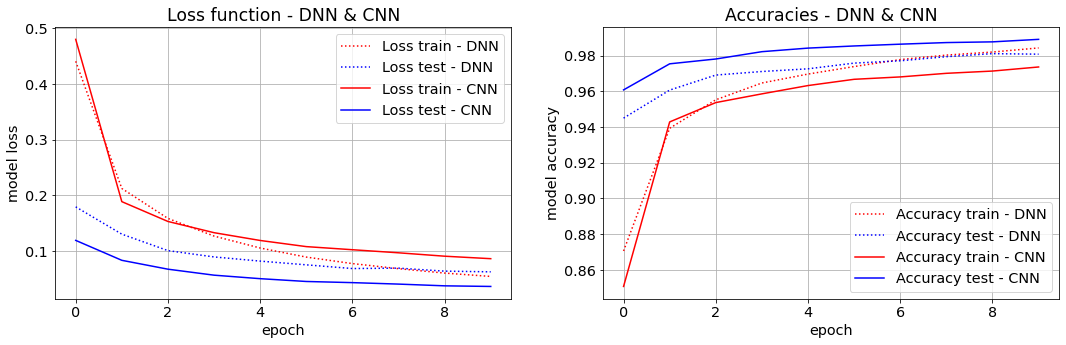

In [133]:
fig, plts=plt.subplots(1,2)
fig.set_figwidth(18)
fig.set_figheight(5)

plts[0].set_title("Loss function - DNN & CNN")
plts[0].plot(histories[3].history['loss'], 'r:')
plts[0].plot(histories[3].history['val_loss'], 'b:')
plts[0].plot(history1.history['loss'], 'r')
plts[0].plot(history1.history['val_loss'], 'b')
plts[0].set_ylabel('model loss')
plts[0].set_xlabel('epoch')
plts[0].legend(['Loss train - DNN', 'Loss test - DNN','Loss train - CNN', 'Loss test - CNN' ], loc='best')
plts[0].grid()

plts[1].set_title("Accuracies - DNN & CNN")
plts[1].plot(histories[3].history['acc'], 'r:')
plts[1].plot(histories[3].history['val_acc'], 'b:')
plts[1].plot(history1.history['acc'], 'r') 
plts[1].plot(history1.history['val_acc'], 'b')
plts[1].legend(['Accuracy train - DNN', 'Accuracy test - DNN','Accuracy train - CNN', 'Accuracy test - CNN' ], loc='best')
plts[1].set_ylabel('model accuracy')
plts[1].set_xlabel('epoch')
#plts[1].legend()
plts[1].grid()

Dal grafico si osserva che, nonostante in fase di training la DNN sia nel complesso più per formante, in fase di test la CNN offre risultati migliori.

Anche in questo caso effettuo un confronto finale tra i due modelli di rete neurale utilizzati. In particolare in questo caso confronto le predizioni della DNN (in cui sono stati specificati i parametri dell'ottimizzatore SGD) e quelle della CNN.

313/313 [==============================] - 0s 705us/step
In ordine: le predizioni della rete convoluzionale e quelle della rete non convoluzionale


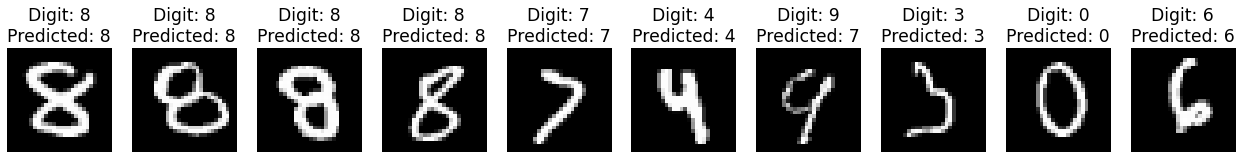

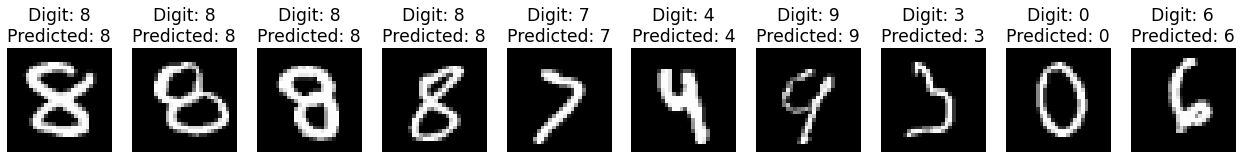

In [61]:
X = X.reshape(X_test.shape[0], img_rows, img_cols,1)
predictions_new = model_CNN.predict(X)

print('In ordine: le predizioni della rete convoluzionale e quelle della rete non convoluzionale')

plt.figure(figsize=(22, 15)) 
for i in range(10):    
    shift = 876
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X[i+shift, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i+shift]), np.argmax(predictions_new[i+shift])))    
    plt.axis('off') 
plt.show()

plt.figure(figsize=(22, 15)) 
for i in range(10):    
    shift = 876
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X[i+shift, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i+shift]), np.argmax(predictions[3][i+shift])))    
    plt.axis('off') 
plt.show()

## Esercizio 3

In questo ultimo esercizio provo a far riconoscere alla rete neurale alcune cifre non presenti nella cartella MNIST.

Image size: 28x28
1/1 [==============================] - 0s 14ms/step


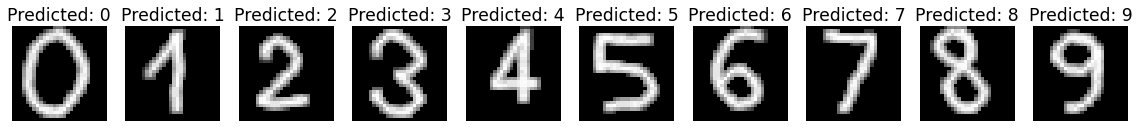

In [120]:
digit_filename = ["imgs/0b.png", "imgs/1b.png", "imgs/2b.png", "imgs/3b.png", "imgs/4b.png", "imgs/5b.png", "imgs/6b.png", "imgs/7b.png", "imgs/8b.png", "imgs/9b.png"]
tot = len(digit_filename)
digit_in = [Image.open(digit_filename).convert('L') for digit_filename in digit_filename]

ydim, xdim = digit_in[0].size
print("Image size: "+str(xdim)+"x"+str(ydim))
pix = [digit_in.load() for digit_in in digit_in];
data = [np.zeros((xdim, ydim)) for i in range(tot)]

for k in range(tot):
    for j in range(ydim):
        for i in range(xdim):
            data[k][i,j]=pix[k][j,i]
            #data[k] /= 255

fig, plts = plt.subplots(1,tot)
fig.set_figwidth(20)
fig.set_figheight(7)
k = 0

for data in data:
    plts[k].imshow(data, cmap='gray')
    plts[k].axis('off') 
    shift = 876
    data = data.reshape(1,xdim,ydim,1)
    predict = model_CNN.predict(data)
    data = data.reshape(xdim,ydim)
    plts[k].set_title("Predicted: {}".format(np.argmax(predict)))
        #plt.title("Digit: {}\nPredicted:{}".format(np.argmax(Y_test[i+shift]), np.argmax(predictions[j][i+shift])))    

    k =k+1

Image size: 28x28
1/1 [==============================] - 0s 13ms/step


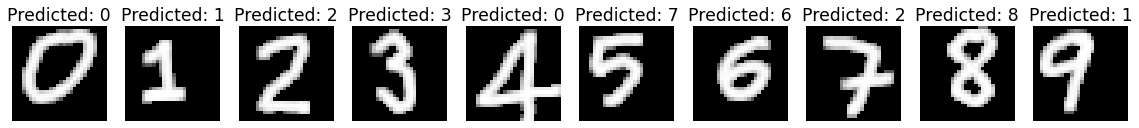

In [115]:
digit_filename = ["imgs/0.png", "imgs/1.png", "imgs/2.png", "imgs/3.png", "imgs/4.png", "imgs/5.png", "imgs/6.png", "imgs/7.png", "imgs/8.png", "imgs/9.png"]
tot = len(digit_filename)
digit_in = [Image.open(digit_filename).convert('L') for digit_filename in digit_filename]

ydim, xdim = digit_in[0].size
print("Image size: "+str(xdim)+"x"+str(ydim))
pix = [digit_in.load() for digit_in in digit_in];
data = [np.zeros((xdim, ydim)) for i in range(tot)]

for k in range(tot):
    for j in range(ydim):
        for i in range(xdim):
            data[k][i,j]=pix[k][j,i]
            #data[k] /= 255

fig, plts = plt.subplots(1,tot)
fig.set_figwidth(20)
fig.set_figheight(7)
k = 0

for data in data:
    plts[k].imshow(data, cmap='gray')
    plts[k].axis('off') 
    shift = 876
    data = data.reshape(1,xdim,ydim,1)
    predict = model_CNN.predict(data)
    data = data.reshape(xdim,ydim)
    plts[k].set_title("Predicted: {}".format(np.argmax(predict)))
        #plt.title("Digit: {}\nPredicted:{}".format(np.argmax(Y_test[i+shift]), np.argmax(predictions[j][i+shift])))    

    k =k+1

Confrontando le predizioni della rete nei due casi quello che si osserva è che mentre nel primo caso, in cui i numeri erano ben scritti, tendenzialmente centrali all'interno dell'immagine, le predizioni della rete neurale sono tutte corrette. 
Nel secondo caso invece, se si osserva il numero 4 ad esempio, il numero tocca i bordi dell'immagine e la rete neurale legge una sorta di *zero sbavato*.
Un altro caso interessante è quella del numero 7, nel caso precedente è stato scritto con la stessa forma con cui la rete neurale ha imparato a riconoscerlo, in questo caso invece, ha interpretato la porzione superiore del 7 come un 2 e la parte inferiore come una sbavatura.

**Filtri**

La rete convoluzionale ha autonomamente imparato ad applicare dei filtri agli imput che le vengono forniti. Di seguito è mostrato il layer iniziale.

In [121]:
layer_index=0
for layer in model_CNN.layers:
    print(layer_index, layer.name)
    layer_index+=1

0 conv2d_2
1 max_pooling2d_2
2 conv2d_3
3 max_pooling2d_3
4 dropout_16
5 flatten_1
6 dense_47
7 dense_48


(5, 5, 1, 10)


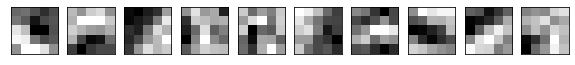

In [122]:
# layer_index should be the index of a convolutional layer
layer_index=0
# retrieve weights from the convolutional hidden layer
filters, biases = model_CNN.layers[layer_index].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
print(filters.shape)

# plot filters
n_filters, ix = filters.shape[3], 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # specify subplot and turn of axis
    ax = plt.subplot(1,n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :, 0], cmap='gray')
    ix += 1
# show the figure
plt.show()

Per fare un esempio osserviamo come viene modificata l'immagine di un 7 a seguto di ciasun layer

In [134]:
test_index = 0

from keras.models import Model
layer_outputs = [layer.output for layer in model_CNN.layers]
activation_model = Model(inputs=model_CNN.input, outputs=layer_outputs)
activations = activation_model.predict(X_test[test_index].reshape(1,28,28,1))
 
def display_activation(activations, col_size, row_size, layer_index): 
    activation = activations[layer_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*3,col_size*3))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

1/1 [==============================] - 0s 46ms/step


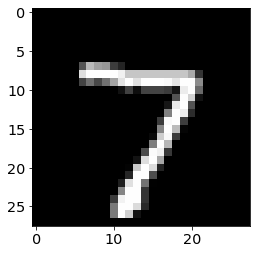

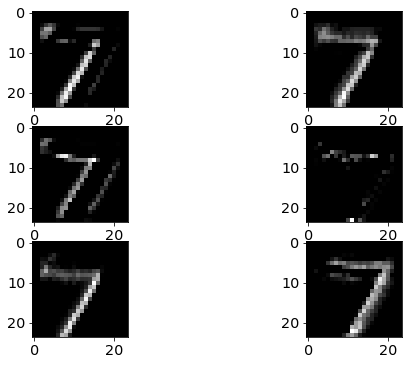

In [135]:
%matplotlib inline
plt.imshow(X_test[test_index][:,:,0], cmap='gray')
display_activation(activations, 2, 3, 0)